In [1]:
APP_PATH = '/root'

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

from PIL import Image

from gradcam import GradCAM, GradCAMpp
from gradcam.utils import visualize_cam


In [2]:
# モデル
device = torch.device("cuda:0" if torch.cuda.is_available()  else "cpu")

n_output = 6
n_hidden = 128

class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
    self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
    self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
    self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
    self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
    self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d((2,2))
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(131072, n_hidden) # 256 v2

    self.l2 = nn.Linear(n_hidden, n_output)
    self.dropout1 = nn.Dropout(0.2)
    self.dropout2 = nn.Dropout(0.3)
    self.dropout3 = nn.Dropout(0.4)
    self.bn1 = nn.BatchNorm2d(32)
    self.bn2 = nn.BatchNorm2d(32)
    self.bn3 = nn.BatchNorm2d(64)
    self.bn4 = nn.BatchNorm2d(64)
    self.bn5 = nn.BatchNorm2d(128)
    self.bn6 = nn.BatchNorm2d(128)


    self.features = nn.Sequential(
        self.conv1,
        self.bn1,
        self.relu,
        self.conv2,
        self.bn2,
        self.relu,
        self.maxpool,
        self.dropout1,
        self.conv3,
        self.bn3,
        self.relu,
        self.conv4,
        self.bn4,
        self.relu,
        self.maxpool,
        self.dropout2,
        self.conv5,
        self.bn5,
        self.relu,
        self.conv6,
        self.bn6,
        self.relu,
        self.maxpool,
        self.dropout3
    )

    self.classifier = nn.Sequential(
        self.l1,
        self.relu,
        self.l2
    )

  def forward(self, x):
    x1 = self.features(x)
    x2 = self.flatten(x1)
    x3 = self.classifier(x2)
    return x3

model = CNN(n_output, n_hidden)


In [3]:
# datasets_npz_x1からそれぞれのlabelで最初のデータを取得
CATEGORIES=["S10C","S15C","S25C","S35C","S45C","S55C"]

datasets_npz_x1 = np.load(APP_PATH + '/dataset_npz/x.1_dataset/sc_x10_960_x1.npz')

images = datasets_npz_x1['x']
labels = datasets_npz_x1['y']

S10C = None
S15C = None
S25C = None
S35C = None
S45C = None
S55C = None

for i, label in enumerate(labels):
  match label:
    case 0:
      if S10C is None:
        S10C = images[i]
    case 1:
      if S15C is None:
        S15C = images[i]
    case 2:
      if S25C is None:
        S25C = images[i]
    case 3:
      if S35C is None:
        S35C = images[i]
    case 4:
      if S45C is None:
        S45C = images[i]
    case 5:
      if S55C is None:
        S55C = images[i]
    case _:
      print("no match")

  if S10C is not None and S15C is not None and S25C is not None and S35C is not None and S45C is not None and S55C is not None:
    break


print("CATEGORIES TYPE: S10C:{}, S15C:{}, S25C:{}, S35C:{}, S45C:{}, S55C:{} ".format(type(S10C), type(S15C), type(S25C), type(S35C), type(S45C), type(S55C)))


CATEGORIES TYPE: S10C:<class 'numpy.ndarray'>, S15C:<class 'numpy.ndarray'>, S25C:<class 'numpy.ndarray'>, S35C:<class 'numpy.ndarray'>, S45C:<class 'numpy.ndarray'>, S55C:<class 'numpy.ndarray'> 


/usr/local/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.10/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


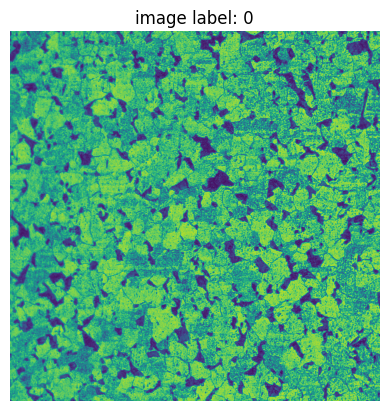

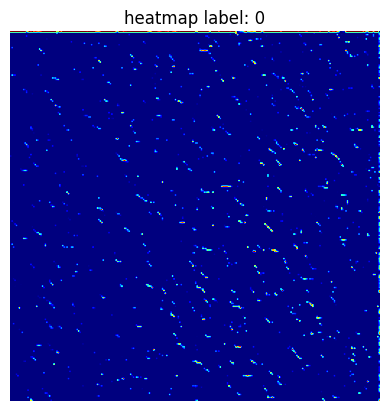

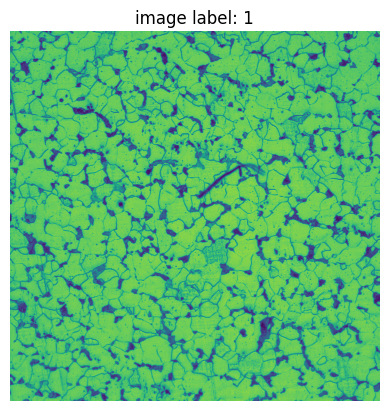

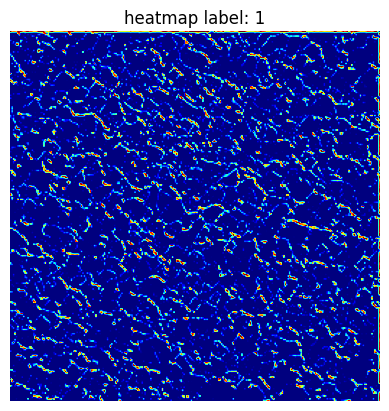

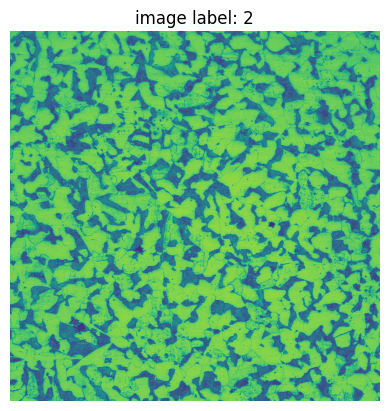

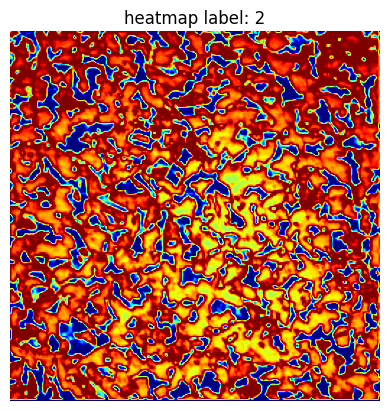

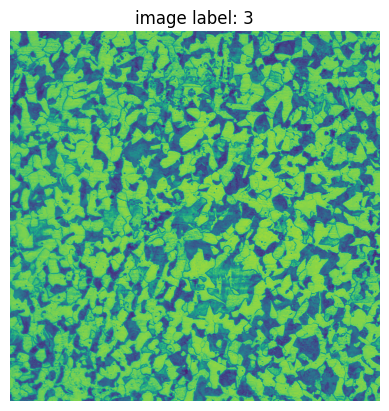

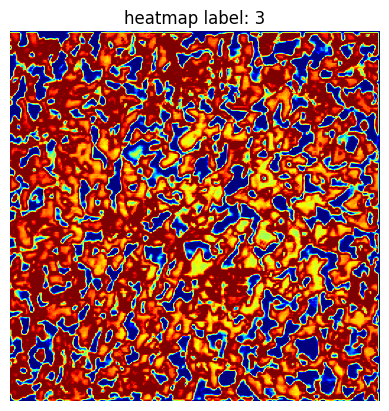

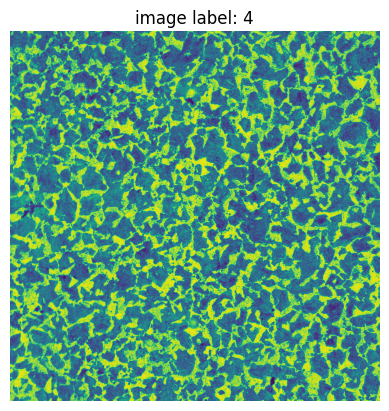

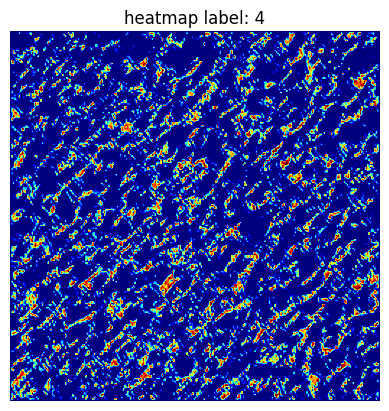

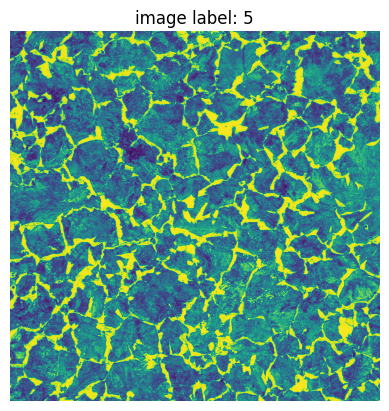

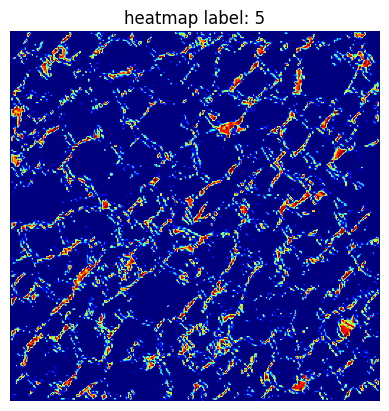

In [4]:
# それぞれでgradcamを表示

def exec_gradcam(model, target_layer, image, label):
  dispaly_image = image

  image = Image.fromarray(image)
  image = image.convert("RGB")
  image = image.resize((256, 256))
  image = np.asarray(image, np.float32)
  image = image.astype(float) / 255.0
  image = torch.from_numpy(image).float().permute(2, 0, 1).unsqueeze(0)

  gradcam = GradCAM(model, target_layer)

  heatmap = gradcam(image, label)

  # ヒートマップを適切な形式に変換(正規化)
  heatmap = heatmap[0].squeeze().cpu().numpy()
  heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
  heatmap = heatmap.astype(np.float32)
  heatmap = torch.from_numpy(heatmap)

  # 元の画像に可視化をオーバーレイ
  visualization = visualize_cam(heatmap, image)

  plt.imshow(dispaly_image)
  plt.axis('off')
  plt.title('image label: {}'.format(label))
  plt.show()

  visualization_np = visualization[0][0].cpu().numpy()
  plt.imshow(visualization_np, cmap='jet')
  plt.axis('off')
  plt.title('heatmap label: {}'.format(label))
  plt.show()


filename = 'AlexNet_model_max_weight.pth'
model.load_state_dict(torch.load(filename, map_location='cpu'))
model.eval()

target_layer = model.features[0]

exec_gradcam(model, target_layer, S10C, 0)
exec_gradcam(model, target_layer, S15C, 1)
exec_gradcam(model, target_layer, S25C, 2)
exec_gradcam(model, target_layer, S35C, 3)
exec_gradcam(model, target_layer, S45C, 4)
exec_gradcam(model, target_layer, S55C, 5)
